In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/735 [..............................] - ETA: 13:58 - loss: 0.1213 - STD: 1.5940e-04 - MAE: 0.3349

 10/735 [..............................] - ETA: 4s - loss: 0.0326 - STD: 2.5281e-04 - MAE: 0.1422   

 18/735 [..............................] - ETA: 4s - loss: 0.0271 - STD: 1.6304e-04 - MAE: 0.1273

 25/735 [>.............................] - ETA: 4s - loss: 0.0223 - STD: 1.3387e-04 - MAE: 0.1141

 32/735 [>.............................] - ETA: 4s - loss: 0.0198 - STD: 1.1577e-04 - MAE: 0.1083

 39/735 [>.............................] - ETA: 4s - loss: 0.0180 - STD: 1.0391e-04 - MAE: 0.1024

 46/735 [>.............................] - ETA: 4s - loss: 0.0167 - STD: 9.6809e-05 - MAE: 0.0980

 54/735 [=>............................] - ETA: 4s - loss: 0.0156 - STD: 9.3065e-05 - MAE: 0.0950

 62/735 [=>............................] - ETA: 4s - loss: 0.0148 - STD: 9.1658e-05 - MAE: 0.0925

 70/735 [=>............................] - ETA: 4s - loss: 0.0142 - STD: 9.2129e-05 - MAE: 0.0904

 77/735 [==>...........................] - ETA: 4s - loss: 0.0137 - STD: 9.4366e-05 - MAE: 0.0892

 84/735 [==>...........................] - ETA: 4s - loss: 0.0134 - STD: 9.7786e-05 - MAE: 0.0881

 91/735 [==>...........................] - ETA: 4s - loss: 0.0130 - STD: 1.0243e-04 - MAE: 0.0871

 99/735 [===>..........................] - ETA: 4s - loss: 0.0127 - STD: 1.0942e-04 - MAE: 0.0862

107/735 [===>..........................] - ETA: 4s - loss: 0.0125 - STD: 1.1804e-04 - MAE: 0.0854

115/735 [===>..........................] - ETA: 4s - loss: 0.0123 - STD: 1.2949e-04 - MAE: 0.0848

123/735 [====>.........................] - ETA: 4s - loss: 0.0120 - STD: 1.4340e-04 - MAE: 0.0841

131/735 [====>.........................] - ETA: 4s - loss: 0.0119 - STD: 1.6145e-04 - MAE: 0.0836

139/735 [====>.........................] - ETA: 4s - loss: 0.0117 - STD: 1.8476e-04 - MAE: 0.0831

147/735 [=====>........................] - ETA: 4s - loss: 0.0116 - STD: 2.1535e-04 - MAE: 0.0826

155/735 [=====>........................] - ETA: 4s - loss: 0.0114 - STD: 2.5524e-04 - MAE: 0.0822

163/735 [=====>........................] - ETA: 4s - loss: 0.0113 - STD: 3.0958e-04 - MAE: 0.0818

171/735 [=====>........................] - ETA: 3s - loss: 0.0112 - STD: 3.8344e-04 - MAE: 0.0814

179/735 [======>.......................] - ETA: 3s - loss: 0.0111 - STD: 4.8980e-04 - MAE: 0.0811

186/735 [======>.......................] - ETA: 3s - loss: 0.0110 - STD: 6.2010e-04 - MAE: 0.0808

193/735 [======>.......................] - ETA: 3s - loss: 0.0109 - STD: 8.0599e-04 - MAE: 0.0805

201/735 [=======>......................] - ETA: 3s - loss: 0.0108 - STD: 0.0011 - MAE: 0.0802    

209/735 [=======>......................] - ETA: 3s - loss: 0.0107 - STD: 0.0016 - MAE: 0.0799

216/735 [=======>......................] - ETA: 3s - loss: 0.0106 - STD: 0.0021 - MAE: 0.0795

224/735 [========>.....................] - ETA: 3s - loss: 0.0105 - STD: 0.0029 - MAE: 0.0792

232/735 [========>.....................] - ETA: 3s - loss: 0.0104 - STD: 0.0038 - MAE: 0.0788

240/735 [========>.....................] - ETA: 3s - loss: 0.0103 - STD: 0.0049 - MAE: 0.0784

247/735 [=========>....................] - ETA: 3s - loss: 0.0102 - STD: 0.0058 - MAE: 0.0781

254/735 [=========>....................] - ETA: 3s - loss: 0.0101 - STD: 0.0067 - MAE: 0.0778

258/735 [=========>....................] - ETA: 4s - loss: 0.0101 - STD: 0.0072 - MAE: 0.0777

267/735 [=========>....................] - ETA: 4s - loss: 0.0100 - STD: 0.0084 - MAE: 0.0773

275/735 [==========>...................] - ETA: 4s - loss: 0.0099 - STD: 0.0093 - MAE: 0.0769

283/735 [==========>...................] - ETA: 3s - loss: 0.0098 - STD: 0.0102 - MAE: 0.0766

290/735 [==========>...................] - ETA: 3s - loss: 0.0098 - STD: 0.0110 - MAE: 0.0763

298/735 [===========>..................] - ETA: 3s - loss: 0.0097 - STD: 0.0119 - MAE: 0.0759

306/735 [===========>..................] - ETA: 3s - loss: 0.0096 - STD: 0.0128 - MAE: 0.0755

313/735 [===========>..................] - ETA: 3s - loss: 0.0095 - STD: 0.0136 - MAE: 0.0752

320/735 [============>.................] - ETA: 3s - loss: 0.0094 - STD: 0.0143 - MAE: 0.0749

327/735 [============>.................] - ETA: 3s - loss: 0.0093 - STD: 0.0152 - MAE: 0.0745

335/735 [============>.................] - ETA: 3s - loss: 0.0092 - STD: 0.0161 - MAE: 0.0741

342/735 [============>.................] - ETA: 3s - loss: 0.0092 - STD: 0.0170 - MAE: 0.0737

350/735 [=============>................] - ETA: 3s - loss: 0.0091 - STD: 0.0179 - MAE: 0.0733

358/735 [=============>................] - ETA: 3s - loss: 0.0090 - STD: 0.0188 - MAE: 0.0729

365/735 [=============>................] - ETA: 3s - loss: 0.0089 - STD: 0.0196 - MAE: 0.0725

373/735 [==============>...............] - ETA: 3s - loss: 0.0088 - STD: 0.0205 - MAE: 0.0721

381/735 [==============>...............] - ETA: 2s - loss: 0.0088 - STD: 0.0214 - MAE: 0.0717

388/735 [==============>...............] - ETA: 2s - loss: 0.0087 - STD: 0.0221 - MAE: 0.0714

395/735 [===============>..............] - ETA: 2s - loss: 0.0086 - STD: 0.0228 - MAE: 0.0711

403/735 [===============>..............] - ETA: 2s - loss: 0.0085 - STD: 0.0236 - MAE: 0.0707

411/735 [===============>..............] - ETA: 2s - loss: 0.0085 - STD: 0.0243 - MAE: 0.0704

418/735 [================>.............] - ETA: 2s - loss: 0.0084 - STD: 0.0250 - MAE: 0.0700

425/735 [================>.............] - ETA: 2s - loss: 0.0083 - STD: 0.0256 - MAE: 0.0697

433/735 [================>.............] - ETA: 2s - loss: 0.0083 - STD: 0.0263 - MAE: 0.0694

441/735 [=================>............] - ETA: 2s - loss: 0.0082 - STD: 0.0270 - MAE: 0.0691

448/735 [=================>............] - ETA: 2s - loss: 0.0082 - STD: 0.0275 - MAE: 0.0689

455/735 [=================>............] - ETA: 2s - loss: 0.0081 - STD: 0.0281 - MAE: 0.0686

463/735 [=================>............] - ETA: 2s - loss: 0.0081 - STD: 0.0287 - MAE: 0.0683

470/735 [==================>...........] - ETA: 2s - loss: 0.0080 - STD: 0.0293 - MAE: 0.0681

476/735 [==================>...........] - ETA: 2s - loss: 0.0080 - STD: 0.0298 - MAE: 0.0678

484/735 [==================>...........] - ETA: 2s - loss: 0.0079 - STD: 0.0304 - MAE: 0.0675

492/735 [===================>..........] - ETA: 1s - loss: 0.0079 - STD: 0.0310 - MAE: 0.0673

499/735 [===================>..........] - ETA: 1s - loss: 0.0078 - STD: 0.0315 - MAE: 0.0670

507/735 [===================>..........] - ETA: 1s - loss: 0.0077 - STD: 0.0320 - MAE: 0.0668

515/735 [====================>.........] - ETA: 1s - loss: 0.0077 - STD: 0.0326 - MAE: 0.0665

522/735 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0331 - MAE: 0.0663

529/735 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0335 - MAE: 0.0660

537/735 [====================>.........] - ETA: 1s - loss: 0.0076 - STD: 0.0340 - MAE: 0.0658

544/735 [=====================>........] - ETA: 1s - loss: 0.0075 - STD: 0.0345 - MAE: 0.0656

551/735 [=====================>........] - ETA: 1s - loss: 0.0075 - STD: 0.0349 - MAE: 0.0654

559/735 [=====================>........] - ETA: 1s - loss: 0.0074 - STD: 0.0353 - MAE: 0.0652

567/735 [======================>.......] - ETA: 1s - loss: 0.0074 - STD: 0.0358 - MAE: 0.0650

575/735 [======================>.......] - ETA: 1s - loss: 0.0073 - STD: 0.0362 - MAE: 0.0647

582/735 [======================>.......] - ETA: 1s - loss: 0.0073 - STD: 0.0366 - MAE: 0.0646

589/735 [=======================>......] - ETA: 1s - loss: 0.0073 - STD: 0.0370 - MAE: 0.0643

596/735 [=======================>......] - ETA: 1s - loss: 0.0072 - STD: 0.0374 - MAE: 0.0642

603/735 [=======================>......] - ETA: 1s - loss: 0.0072 - STD: 0.0378 - MAE: 0.0640

610/735 [=======================>......] - ETA: 0s - loss: 0.0072 - STD: 0.0381 - MAE: 0.0638

618/735 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0386 - MAE: 0.0636

625/735 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0389 - MAE: 0.0634

633/735 [========================>.....] - ETA: 0s - loss: 0.0071 - STD: 0.0393 - MAE: 0.0632

640/735 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0396 - MAE: 0.0631

648/735 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0400 - MAE: 0.0629

655/735 [=========================>....] - ETA: 0s - loss: 0.0070 - STD: 0.0403 - MAE: 0.0627

663/735 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0406 - MAE: 0.0626

669/735 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0409 - MAE: 0.0624

676/735 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0412 - MAE: 0.0623

683/735 [==========================>...] - ETA: 0s - loss: 0.0068 - STD: 0.0415 - MAE: 0.0621

690/735 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0418 - MAE: 0.0620

697/735 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0421 - MAE: 0.0618

705/735 [===========================>..] - ETA: 0s - loss: 0.0068 - STD: 0.0424 - MAE: 0.0617

713/735 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0427 - MAE: 0.0615

721/735 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0430 - MAE: 0.0614

729/735 [============================>.] - ETA: 0s - loss: 0.0067 - STD: 0.0433 - MAE: 0.0612

735/735 [==============================] - 8s 9ms/step - loss: 0.0066 - STD: 0.0435 - MAE: 0.0611 - val_loss: 0.0035 - val_STD: 0.0583 - val_MAE: 0.0453


Epoch 2/10000


  1/735 [..............................] - ETA: 19s - loss: 0.0041 - STD: 0.0765 - MAE: 0.0504

  9/735 [..............................] - ETA: 5s - loss: 0.0041 - STD: 0.0723 - MAE: 0.0482 

 16/735 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0475

 23/735 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0470

 31/735 [>.............................] - ETA: 5s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0469

 39/735 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0469

 47/735 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0469

 54/735 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0469

 62/735 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0468

 69/735 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0468

 76/735 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0468

 83/735 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0467

 90/735 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0467

 96/735 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

101/735 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

106/735 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0466

111/735 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

117/735 [===>..........................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

124/735 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

131/735 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

138/735 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

144/735 [====>.........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

149/735 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

154/735 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0464

160/735 [=====>........................] - ETA: 4s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0464

167/735 [=====>........................] - ETA: 4s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0463

173/735 [======>.......................] - ETA: 4s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0463

179/735 [======>.......................] - ETA: 4s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0462

186/735 [======>.......................] - ETA: 4s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

192/735 [======>.......................] - ETA: 4s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

198/735 [=======>......................] - ETA: 4s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

205/735 [=======>......................] - ETA: 4s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

212/735 [=======>......................] - ETA: 4s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

219/735 [=======>......................] - ETA: 4s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0462

226/735 [========>.....................] - ETA: 4s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

232/735 [========>.....................] - ETA: 4s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

238/735 [========>.....................] - ETA: 4s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461

246/735 [=========>....................] - ETA: 4s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461

253/735 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461

260/735 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

267/735 [=========>....................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

274/735 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

282/735 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

288/735 [==========>...................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

295/735 [===========>..................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0459

302/735 [===========>..................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

309/735 [===========>..................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

316/735 [===========>..................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0459

324/735 [============>.................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

331/735 [============>.................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

339/735 [============>.................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

347/735 [=============>................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

354/735 [=============>................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

362/735 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

370/735 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

377/735 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

384/735 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

392/735 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

399/735 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0456

407/735 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0456

415/735 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0456

423/735 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

431/735 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

439/735 [================>.............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

447/735 [=================>............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

454/735 [=================>............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0456

462/735 [=================>............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0456

470/735 [==================>...........] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0456

478/735 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0456

486/735 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0456

494/735 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0455

502/735 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0455

509/735 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0455

516/735 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

523/735 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

531/735 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

539/735 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

547/735 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

555/735 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

563/735 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

570/735 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

578/735 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

586/735 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

594/735 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

602/735 [=======================>......] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

610/735 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

618/735 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

626/735 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

633/735 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

639/735 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

647/735 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

655/735 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

663/735 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

671/735 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

678/735 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

685/735 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

693/735 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

701/735 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

708/735 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

715/735 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

722/735 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

729/735 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

735/735 [==============================] - 6s 8ms/step - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450 - val_loss: 0.0035 - val_STD: 0.0560 - val_MAE: 0.0422


Epoch 3/10000


  1/735 [..............................] - ETA: 21s - loss: 0.0043 - STD: 0.0762 - MAE: 0.0457

  7/735 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453 

 14/735 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0749 - MAE: 0.0455

 21/735 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0458

 28/735 [>.............................] - ETA: 5s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0456

 35/735 [>.............................] - ETA: 5s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

 42/735 [>.............................] - ETA: 5s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0449

 49/735 [=>............................] - ETA: 5s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

 57/735 [=>............................] - ETA: 5s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

 64/735 [=>............................] - ETA: 5s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

 71/735 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

 78/735 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

 85/735 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

 92/735 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

 99/735 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

106/735 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

113/735 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

120/735 [===>..........................] - ETA: 4s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

127/735 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

134/735 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

141/735 [====>.........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

148/735 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

155/735 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

162/735 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

169/735 [=====>........................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

177/735 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

184/735 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

190/735 [======>.......................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

197/735 [=======>......................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

204/735 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

211/735 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

218/735 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

225/735 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

232/735 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

239/735 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

246/735 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

253/735 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

261/735 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

268/735 [=========>....................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

275/735 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

282/735 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

289/735 [==========>...................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

296/735 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

304/735 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

311/735 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

318/735 [===========>..................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

325/735 [============>.................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

332/735 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

340/735 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

348/735 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

355/735 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

361/735 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

368/735 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

375/735 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

383/735 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

390/735 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

397/735 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

404/735 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

411/735 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

418/735 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

425/735 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

432/735 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

439/735 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

446/735 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

453/735 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

460/735 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

467/735 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

474/735 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

481/735 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

489/735 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

496/735 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

503/735 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

510/735 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

517/735 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

524/735 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

531/735 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

538/735 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

545/735 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

552/735 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

559/735 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0434

566/735 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

574/735 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

581/735 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

588/735 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

595/735 [=======================>......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

602/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

609/735 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

616/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

623/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

630/735 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

638/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

646/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

654/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

661/735 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

668/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

676/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

683/735 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

691/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

699/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

707/735 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

715/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

722/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

729/735 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

735/735 [==============================] - 6s 8ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433 - val_loss: 0.0031 - val_STD: 0.0561 - val_MAE: 0.0399


Epoch 4/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0034 - STD: 0.0711 - MAE: 0.0411

  9/735 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0429 

 16/735 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0430

 23/735 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

 30/735 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

 37/735 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

 44/735 [>.............................] - ETA: 5s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

 51/735 [=>............................] - ETA: 5s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

 58/735 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

 66/735 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

 74/735 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

 80/735 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

 88/735 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

 96/735 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

104/735 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

111/735 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

119/735 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

126/735 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

134/735 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

141/735 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

149/735 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

156/735 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

163/735 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

170/735 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

177/735 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

184/735 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

192/735 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

200/735 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

208/735 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

216/735 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

224/735 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

232/735 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

240/735 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

248/735 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

254/735 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

262/735 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

269/735 [=========>....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

277/735 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

284/735 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

291/735 [==========>...................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

298/735 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

306/735 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

312/735 [===========>..................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

320/735 [============>.................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

327/735 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

334/735 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

342/735 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

349/735 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

357/735 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

365/735 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

373/735 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

381/735 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

389/735 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

397/735 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

405/735 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

413/735 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

421/735 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

429/735 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

437/735 [================>.............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

445/735 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

453/735 [=================>............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

460/735 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

467/735 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

474/735 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

481/735 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

489/735 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

496/735 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

503/735 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

510/735 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

518/735 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

526/735 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

534/735 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

542/735 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

550/735 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

558/735 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

566/735 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

573/735 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

580/735 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

588/735 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

596/735 [=======================>......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

604/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

612/735 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

620/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

627/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

634/735 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

642/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

650/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

657/735 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

664/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

672/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

680/735 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

687/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

694/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

701/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

708/735 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

716/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

724/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

731/735 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

735/735 [==============================] - 6s 8ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421 - val_loss: 0.0029 - val_STD: 0.0600 - val_MAE: 0.0392


Epoch 5/10000


  1/735 [..............................] - ETA: 17s - loss: 0.0028 - STD: 0.0779 - MAE: 0.0402

  7/735 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0422 

 14/735 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0417

 21/735 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0414

 29/735 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0415

 36/735 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0416

 43/735 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

 51/735 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

 58/735 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

 65/735 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

 72/735 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

 79/735 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

 87/735 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

 94/735 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

102/735 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

110/735 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

118/735 [===>..........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

126/735 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

133/735 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

141/735 [====>.........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

149/735 [=====>........................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

155/735 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

162/735 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

170/735 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

177/735 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

185/735 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

193/735 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

200/735 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

208/735 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

215/735 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

223/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

231/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

238/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

245/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

252/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

259/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

266/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

274/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

281/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

289/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

296/735 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

303/735 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

311/735 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

319/735 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

327/735 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

334/735 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

341/735 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

348/735 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

355/735 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

362/735 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

370/735 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

377/735 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

385/735 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

392/735 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

399/735 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

406/735 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

414/735 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

421/735 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

428/735 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

436/735 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0414

443/735 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

450/735 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

457/735 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

464/735 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

471/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

478/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

486/735 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

493/735 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

500/735 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

508/735 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

516/735 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

523/735 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

530/735 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

537/735 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

544/735 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

551/735 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

558/735 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

566/735 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

573/735 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

580/735 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

587/735 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

594/735 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

602/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

609/735 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

616/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

623/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

631/735 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

639/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

646/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

653/735 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

660/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

667/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

675/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

682/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

689/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

697/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

704/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

711/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

719/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

726/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

733/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

735/735 [==============================] - 6s 8ms/step - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413 - val_loss: 0.0029 - val_STD: 0.0627 - val_MAE: 0.0401


Epoch 6/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0028 - STD: 0.0823 - MAE: 0.0400

  7/735 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0815 - MAE: 0.0398 

 14/735 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

 21/735 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

 28/735 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

 35/735 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

 42/735 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

 49/735 [=>............................] - ETA: 5s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

 56/735 [=>............................] - ETA: 5s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

 63/735 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0412

 70/735 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0412

 77/735 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

 84/735 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

 92/735 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

 99/735 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

106/735 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

113/735 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

121/735 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

128/735 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

135/735 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

142/735 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

149/735 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

157/735 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

165/735 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

173/735 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

180/735 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

187/735 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

194/735 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

201/735 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

208/735 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

216/735 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

223/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

230/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

238/735 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

245/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

253/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

260/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

268/735 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

275/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

282/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

289/735 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

297/735 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

305/735 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

313/735 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

321/735 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

327/735 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

334/735 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

341/735 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

348/735 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

356/735 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

363/735 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

370/735 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

377/735 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

385/735 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

392/735 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

400/735 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

408/735 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

414/735 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

420/735 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

427/735 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

434/735 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

441/735 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

448/735 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

455/735 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

462/735 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

468/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

475/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

482/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

488/735 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

495/735 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

500/735 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

507/735 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

515/735 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

522/735 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

530/735 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

537/735 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

544/735 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

552/735 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

559/735 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

566/735 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

574/735 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

581/735 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

589/735 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

596/735 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

603/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

610/735 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

617/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

624/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

631/735 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

638/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

645/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

652/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

659/735 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

667/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

675/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

682/735 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

689/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

696/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

703/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

710/735 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

718/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

725/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

733/735 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

735/735 [==============================] - 6s 8ms/step - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407 - val_loss: 0.0032 - val_STD: 0.0571 - val_MAE: 0.0397


Epoch 7/10000


  1/735 [..............................] - ETA: 17s - loss: 0.0033 - STD: 0.0731 - MAE: 0.0422

  8/735 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0405 

 16/735 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0407

 24/735 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0407

 32/735 [>.............................] - ETA: 5s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 40/735 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

 48/735 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

 56/735 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

 63/735 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

 70/735 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

 78/735 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

 86/735 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0405

 94/735 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

102/735 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

110/735 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

118/735 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

125/735 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

132/735 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

139/735 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

146/735 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

153/735 [=====>........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

160/735 [=====>........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

167/735 [=====>........................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

174/735 [======>.......................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

182/735 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

189/735 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

196/735 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

203/735 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

211/735 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

219/735 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

227/735 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

235/735 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

243/735 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

250/735 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

258/735 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

266/735 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

273/735 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

280/735 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

287/735 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

295/735 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

303/735 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

311/735 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

318/735 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

325/735 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

332/735 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

339/735 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

347/735 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

355/735 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

363/735 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

370/735 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

378/735 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

384/735 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

390/735 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

398/735 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

406/735 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

414/735 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

422/735 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

429/735 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

437/735 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

444/735 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

452/735 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

459/735 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

467/735 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

475/735 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

483/735 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

491/735 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

499/735 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

507/735 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

515/735 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

523/735 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

531/735 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

539/735 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

546/735 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

554/735 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

562/735 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

569/735 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

576/735 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

583/735 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

590/735 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

597/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

604/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

611/735 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

618/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

626/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

634/735 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

641/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

648/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

656/735 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

663/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

671/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

679/735 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

687/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

694/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

701/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

708/735 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

716/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

723/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

731/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

735/735 [==============================] - 6s 8ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399 - val_loss: 0.0028 - val_STD: 0.0640 - val_MAE: 0.0398


Epoch 8/10000


  1/735 [..............................] - ETA: 21s - loss: 0.0032 - STD: 0.0823 - MAE: 0.0424

  8/735 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406 

 15/735 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

 22/735 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

 30/735 [>.............................] - ETA: 5s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

 38/735 [>.............................] - ETA: 5s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

 45/735 [>.............................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

 53/735 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

 60/735 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

 68/735 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

 75/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

 82/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

 90/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

 97/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

104/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

111/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

119/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

127/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

135/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

143/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

150/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

156/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

163/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

171/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

179/735 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

186/735 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

194/735 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

201/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

208/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

216/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

223/735 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

231/735 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

239/735 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

246/735 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

254/735 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

262/735 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

269/735 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

276/735 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

283/735 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

291/735 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

298/735 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

305/735 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

312/735 [===========>..................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

319/735 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

326/735 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

333/735 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

341/735 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

349/735 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

356/735 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

363/735 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

370/735 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

377/735 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

385/735 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

392/735 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

400/735 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

408/735 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

416/735 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

424/735 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

431/735 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

438/735 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

445/735 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

453/735 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

461/735 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

469/735 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

477/735 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

485/735 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

493/735 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

501/735 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

509/735 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

517/735 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

525/735 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

533/735 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

540/735 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

548/735 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

556/735 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

564/735 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

571/735 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

579/735 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

587/735 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

595/735 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

602/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

610/735 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

618/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

625/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

633/735 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

641/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

649/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

657/735 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

664/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

672/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

679/735 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

687/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

695/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

703/735 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

711/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

719/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

727/735 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

735/735 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

735/735 [==============================] - 6s 8ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393 - val_loss: 0.0028 - val_STD: 0.0631 - val_MAE: 0.0383


Epoch 9/10000


  1/735 [..............................] - ETA: 18s - loss: 0.0028 - STD: 0.0814 - MAE: 0.0394

  7/735 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389 

 15/735 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

 23/735 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

 31/735 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0390

 39/735 [>.............................] - ETA: 5s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

 46/735 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0391

 53/735 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

 60/735 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

 67/735 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

 75/735 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

 82/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

 89/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

 97/735 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

104/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

111/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

119/735 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

126/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

133/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

140/735 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

148/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

156/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

164/735 [=====>........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

172/735 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

180/735 [======>.......................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

187/735 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

195/735 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

202/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

210/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

217/735 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

224/735 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

231/735 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

238/735 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

245/735 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

252/735 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

260/735 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

267/735 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

274/735 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

282/735 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

290/735 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

298/735 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

306/735 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

314/735 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

321/735 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

329/735 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

337/735 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

345/735 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

353/735 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

360/735 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

368/735 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

376/735 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

384/735 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

391/735 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

399/735 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

407/735 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

415/735 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

423/735 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

431/735 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

439/735 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

447/735 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

455/735 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

463/735 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

471/735 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

479/735 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

487/735 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

495/735 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

503/735 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

511/735 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

519/735 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

527/735 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

535/735 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

543/735 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

551/735 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

559/735 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

567/735 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

574/735 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

582/735 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

590/735 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

597/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

604/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

612/735 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

620/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

627/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

634/735 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

641/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

648/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

656/735 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

662/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

669/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

675/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

682/735 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

690/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

697/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

704/735 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

711/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

719/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

726/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

734/735 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

735/735 [==============================] - 6s 8ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388 - val_loss: 0.0027 - val_STD: 0.0650 - val_MAE: 0.0381


Epoch 10/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0023 - STD: 0.0857 - MAE: 0.0364

  8/735 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0378 

 15/735 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0815 - MAE: 0.0383

 22/735 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0814 - MAE: 0.0382

 29/735 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0383

 36/735 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0381

 43/735 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0813 - MAE: 0.0381

 50/735 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0813 - MAE: 0.0382

 57/735 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0381

 65/735 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0382

 72/735 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0810 - MAE: 0.0382

 79/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0383

 86/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0383

 93/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0382

101/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

109/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

116/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0383

123/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

130/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

137/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

144/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

152/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

159/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

166/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

174/735 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

181/735 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

188/735 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

195/735 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

203/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

211/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

218/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

225/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

232/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

239/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

246/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

253/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

260/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

267/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

274/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

282/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

289/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

296/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

304/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

312/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

320/735 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

327/735 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

335/735 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

343/735 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

350/735 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

357/735 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

364/735 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

371/735 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

378/735 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

386/735 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

394/735 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

402/735 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

410/735 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

418/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

425/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

432/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

439/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

447/735 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

455/735 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

463/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

471/735 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

478/735 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

486/735 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

494/735 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

501/735 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

509/735 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

516/735 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

524/735 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

532/735 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

539/735 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

547/735 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

554/735 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

562/735 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

570/735 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

578/735 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

585/735 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

592/735 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

599/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

606/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

613/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

621/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

628/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

635/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

642/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

649/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

657/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

664/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

671/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

679/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

686/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

694/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

701/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

709/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

717/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

725/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

733/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

735/735 [==============================] - 6s 8ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382 - val_loss: 0.0027 - val_STD: 0.0643 - val_MAE: 0.0375


Epoch 11/10000


  1/735 [..............................] - ETA: 19s - loss: 0.0024 - STD: 0.0781 - MAE: 0.0365

  8/735 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0377 

 16/735 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0810 - MAE: 0.0377

 23/735 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

 30/735 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

 38/735 [>.............................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

 45/735 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

 52/735 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

 59/735 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

 66/735 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

 73/735 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

 80/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

 87/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

 95/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

102/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

109/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

117/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

125/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

132/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

140/735 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

147/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

154/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

162/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

169/735 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

177/735 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

184/735 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

191/735 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

199/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

206/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

214/735 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

222/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

230/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

238/735 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

246/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

254/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

262/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

269/735 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

277/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

285/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

293/735 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

300/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

308/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

316/735 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

324/735 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

332/735 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

339/735 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

347/735 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

354/735 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

362/735 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

370/735 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

377/735 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

385/735 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

393/735 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

401/735 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

409/735 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

417/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

424/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

432/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

439/735 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

446/735 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

453/735 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

460/735 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

467/735 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

475/735 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

483/735 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

491/735 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

499/735 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

507/735 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

514/735 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

522/735 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

530/735 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

537/735 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

544/735 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

551/735 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

558/735 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

566/735 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

574/735 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

582/735 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

589/735 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

597/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

605/735 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

614/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

622/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

630/735 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

637/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

644/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

651/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

659/735 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

667/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

675/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

683/735 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

691/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

698/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

705/735 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

712/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

720/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

728/735 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

735/735 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

735/735 [==============================] - 6s 8ms/step - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379 - val_loss: 0.0027 - val_STD: 0.0637 - val_MAE: 0.0371


Epoch 12/10000


  1/735 [..............................] - ETA: 20s - loss: 0.0024 - STD: 0.0769 - MAE: 0.0363

  8/735 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396 

 15/735 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

 22/735 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0386

 29/735 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

 36/735 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

 43/735 [>.............................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

 50/735 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

 57/735 [=>............................] - ETA: 5s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

 64/735 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

 71/735 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

 78/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0379

 85/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

 93/735 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

101/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

109/735 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

116/735 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

123/735 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

130/735 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

137/735 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

144/735 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0376

151/735 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0375

158/735 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

165/735 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

172/735 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

179/735 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

186/735 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

193/735 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

200/735 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

207/735 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

214/735 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

221/735 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

229/735 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

236/735 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

244/735 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

251/735 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

258/735 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

266/735 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

273/735 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

280/735 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0376

287/735 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

294/735 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

302/735 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

310/735 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

318/735 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

326/735 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

333/735 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

340/735 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

348/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

355/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0376

363/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

370/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

377/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

383/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

390/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

397/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

404/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

412/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

419/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

427/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

434/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

441/735 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

448/735 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

455/735 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

462/735 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

469/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

476/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

483/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

490/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

497/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

504/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

511/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

518/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

525/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

532/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

539/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

546/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

553/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

560/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

568/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

575/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

582/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

589/735 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

596/735 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

604/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

612/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

619/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

627/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

634/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

641/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

649/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

656/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

663/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

670/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

677/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

685/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

692/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

699/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

706/735 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

713/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

721/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

728/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

735/735 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374

735/735 [==============================] - 6s 8ms/step - loss: 0.0026 - STD: 0.0809 - MAE: 0.0374 - val_loss: 0.0027 - val_STD: 0.0655 - val_MAE: 0.0373


Epoch 13/10000


  1/735 [..............................] - ETA: 21s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0356

  8/735 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0812 - MAE: 0.0362 

 15/735 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

 22/735 [..............................] - ETA: 5s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0368

 30/735 [>.............................] - ETA: 5s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

 38/735 [>.............................] - ETA: 5s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

 46/735 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0371

 54/735 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

 62/735 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0370

 70/735 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

 77/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

 84/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

 91/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

 98/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

106/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

113/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

120/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

128/735 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0370

136/735 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0370

144/735 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0815 - MAE: 0.0371

152/735 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0371

160/735 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0371

168/735 [=====>........................] - ETA: 4s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0371

176/735 [======>.......................] - ETA: 4s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0372

184/735 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

192/735 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0372

199/735 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

207/735 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

215/735 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

223/735 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

230/735 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

238/735 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

246/735 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

254/735 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

262/735 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

269/735 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

276/735 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

284/735 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

292/735 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0374

300/735 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

308/735 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

316/735 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

324/735 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0373

332/735 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0373

339/735 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

347/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

354/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0372

361/735 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

369/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

377/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

385/735 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

393/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0372

401/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

409/735 [===============>..............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

417/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

425/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0372

432/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

439/735 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

446/735 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

454/735 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

462/735 [=================>............] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

469/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

476/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

483/735 [==================>...........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

490/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

497/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

504/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

512/735 [===================>..........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

519/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

527/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

535/735 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

542/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

549/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

557/735 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

564/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

572/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0371

579/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

586/735 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

594/735 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

602/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

610/735 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

618/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

625/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

632/735 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

640/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

647/735 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

655/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

663/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

672/735 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

681/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

690/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

698/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

707/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

715/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

724/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

733/735 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

735/735 [==============================] - 5s 7ms/step - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370 - val_loss: 0.0028 - val_STD: 0.0649 - val_MAE: 0.0384


Epoch 14/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0024 - STD: 0.0810 - MAE: 0.0364

  9/735 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0355 

 17/735 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0360

 26/735 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

 35/735 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

 43/735 [>.............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

 51/735 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369

 60/735 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0368

 69/735 [=>............................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0368

 78/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0367

 86/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0367

 95/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0368

104/735 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0821 - MAE: 0.0367

113/735 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0369

122/735 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0369

131/735 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0369

140/735 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0369

149/735 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0368

158/735 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0368

167/735 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369

175/735 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0370

184/735 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0816 - MAE: 0.0370

193/735 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0370

202/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0369

211/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369

220/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0369

229/735 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369

238/735 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0369

247/735 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0369

256/735 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0370

265/735 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0370

273/735 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

282/735 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0369

291/735 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

300/735 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

309/735 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

318/735 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

327/735 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

336/735 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

345/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

354/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

363/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

372/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

381/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

390/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

399/735 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

408/735 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

416/735 [===============>..............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

425/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

434/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

443/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

452/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

461/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

470/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

479/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0368

488/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

497/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

506/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0367

515/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

523/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

532/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

541/735 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

550/735 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

559/735 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

568/735 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

577/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

586/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

595/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

604/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

613/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0367

622/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366

631/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

639/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

648/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

657/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

666/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

674/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

683/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

692/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

700/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

709/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

718/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

727/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366

735/735 [==============================] - 5s 6ms/step - loss: 0.0025 - STD: 0.0816 - MAE: 0.0366 - val_loss: 0.0027 - val_STD: 0.0650 - val_MAE: 0.0373


Epoch 15/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0024 - STD: 0.0885 - MAE: 0.0362

 10/735 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0356 

 19/735 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0358

 27/735 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0358

 35/735 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0361

 43/735 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0363

 51/735 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0363

 59/735 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

 67/735 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0363

 75/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0364

 84/735 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0363

 93/735 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0364

101/735 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0365

109/735 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0365

117/735 [===>..........................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

125/735 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0365

134/735 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0365

143/735 [====>.........................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0364

151/735 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0365

159/735 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0365

168/735 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

176/735 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0366

184/735 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0366

192/735 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0365

200/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0365

209/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0365

218/735 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0820 - MAE: 0.0364

227/735 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0364

236/735 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0364

245/735 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

254/735 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

263/735 [=========>....................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0364

271/735 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

279/735 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

287/735 [==========>...................] - ETA: 2s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0365

295/735 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

303/735 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

311/735 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

319/735 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

326/735 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

334/735 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0366

343/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

352/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

361/735 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

369/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

377/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

385/735 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

393/735 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

401/735 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

410/735 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

419/735 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

427/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

435/735 [================>.............] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

443/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

451/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

459/735 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

467/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

476/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

484/735 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

493/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

502/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

511/735 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

520/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

529/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0365

537/735 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

546/735 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

555/735 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

564/735 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

573/735 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

582/735 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

591/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

600/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

609/735 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

618/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

626/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

635/735 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0819 - MAE: 0.0364

644/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

652/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

661/735 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

670/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

679/735 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

687/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

695/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0818 - MAE: 0.0364

704/735 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

713/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

722/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

730/735 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365

735/735 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0817 - MAE: 0.0365 - val_loss: 0.0027 - val_STD: 0.0669 - val_MAE: 0.0384


Epoch 16/10000


  1/735 [..............................] - ETA: 16s - loss: 0.0022 - STD: 0.0839 - MAE: 0.0356

  9/735 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0351 

 18/735 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0351

 27/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

 36/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0354

 44/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0352

 52/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0352

 60/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0353

 68/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0822 - MAE: 0.0354

 77/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0355

 86/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

 95/735 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0355

103/735 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0821 - MAE: 0.0356

111/735 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0356

120/735 [===>..........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0356

129/735 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

138/735 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

147/735 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0357

156/735 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

165/735 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

174/735 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

183/735 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

192/735 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

201/735 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

210/735 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

219/735 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

228/735 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

237/735 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

246/735 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0359

255/735 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

264/735 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

273/735 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

282/735 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

291/735 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

300/735 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

309/735 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

318/735 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

327/735 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

336/735 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

345/735 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

354/735 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

362/735 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

370/735 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

378/735 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

387/735 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

396/735 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

405/735 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

414/735 [===============>..............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

422/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

431/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

440/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

449/735 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

458/735 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

467/735 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

476/735 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0358

485/735 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

494/735 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

503/735 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

511/735 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

520/735 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

529/735 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

538/735 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0359

547/735 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0359

556/735 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

565/735 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0359

574/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0359

583/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0820 - MAE: 0.0359

592/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

601/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

610/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

619/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

628/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

637/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

646/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

655/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

663/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

671/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

680/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

689/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

698/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0821 - MAE: 0.0359

707/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

716/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

725/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

734/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

735/735 [==============================] - 5s 6ms/step - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359 - val_loss: 0.0027 - val_STD: 0.0661 - val_MAE: 0.0380


Epoch 17/10000


  1/735 [..............................] - ETA: 17s - loss: 0.0021 - STD: 0.0820 - MAE: 0.0342

  9/735 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0835 - MAE: 0.0354 

 17/735 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0353

 26/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0352

 35/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0354

 44/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

 52/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

 60/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0353

 68/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0833 - MAE: 0.0352

 76/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0352

 84/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0352

 92/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

100/735 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0352

108/735 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

117/735 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

125/735 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0355

134/735 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0356

143/735 [====>.........................] - ETA: 3s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

151/735 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

160/735 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

168/735 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

176/735 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0357

184/735 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

192/735 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0357

201/735 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

209/735 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0356

217/735 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

225/735 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

234/735 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

242/735 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0356

251/735 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

259/735 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

267/735 [=========>....................] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

276/735 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

285/735 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0357

293/735 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0827 - MAE: 0.0356

301/735 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

310/735 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

318/735 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

326/735 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

335/735 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

343/735 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

352/735 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

360/735 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

368/735 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

376/735 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

384/735 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

392/735 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

400/735 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

409/735 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

416/735 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

424/735 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

433/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

440/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

449/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

457/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

466/735 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0826 - MAE: 0.0356

475/735 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

483/735 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

491/735 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

500/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

508/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

517/735 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

526/735 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

534/735 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

543/735 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

552/735 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

561/735 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

569/735 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

577/735 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

586/735 [======================>.......] - ETA: 0s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

594/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

602/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

611/735 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

619/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

628/735 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0356

637/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0825 - MAE: 0.0357

646/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

654/735 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

663/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

672/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

681/735 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

689/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

697/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

706/735 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

714/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

722/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0357

731/735 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356

735/735 [==============================] - 5s 7ms/step - loss: 0.0024 - STD: 0.0824 - MAE: 0.0356 - val_loss: 0.0027 - val_STD: 0.0677 - val_MAE: 0.0386


Epoch 18/10000


  1/735 [..............................] - ETA: 15s - loss: 0.0025 - STD: 0.0832 - MAE: 0.0374

  9/735 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0842 - MAE: 0.0354 

 17/735 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0842 - MAE: 0.0355

 26/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0352

 34/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0834 - MAE: 0.0351

 42/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0352

 51/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

 60/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0353

 69/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0832 - MAE: 0.0354

 77/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0356

 86/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0356

 95/735 [==>...........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

104/735 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0355

113/735 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

122/735 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

131/735 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

140/735 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

149/735 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

158/735 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

166/735 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0352

175/735 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0352

184/735 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

193/735 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

201/735 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

209/735 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

217/735 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

226/735 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

235/735 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

243/735 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

251/735 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

260/735 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

269/735 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

278/735 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

287/735 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

295/735 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

303/735 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

312/735 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

320/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

329/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

338/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

347/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

355/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

363/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

371/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

380/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

388/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

397/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

404/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

412/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

420/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

428/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

437/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0353

446/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

455/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0354

464/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

473/735 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

482/735 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

491/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

499/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

507/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

516/735 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

525/735 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

533/735 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

541/735 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0354

549/735 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

558/735 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

567/735 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

576/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

585/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

594/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

602/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

610/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

618/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

626/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

635/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

644/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

652/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

660/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0353

667/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

676/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

684/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

693/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

701/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

709/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

717/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

726/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

734/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

735/735 [==============================] - 5s 7ms/step - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353 - val_loss: 0.0028 - val_STD: 0.0624 - val_MAE: 0.0383


Epoch 19/10000


  1/735 [..............................] - ETA: 19s - loss: 0.0022 - STD: 0.0761 - MAE: 0.0348

  8/735 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0350 

 16/735 [..............................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0352

 24/735 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0828 - MAE: 0.0357

 33/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0824 - MAE: 0.0356

 42/735 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0820 - MAE: 0.0356

 51/735 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0825 - MAE: 0.0356

 60/735 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0356

 69/735 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0823 - MAE: 0.0356

 78/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0355

 86/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0823 - MAE: 0.0355

 95/735 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0826 - MAE: 0.0354

104/735 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

113/735 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0353

122/735 [===>..........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

131/735 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

140/735 [====>.........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

149/735 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

158/735 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

167/735 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0352

176/735 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

185/735 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0352

194/735 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0827 - MAE: 0.0351

203/735 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

212/735 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

220/735 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

228/735 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

236/735 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0351

244/735 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

252/735 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0828 - MAE: 0.0350

261/735 [=========>....................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

270/735 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

278/735 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

286/735 [==========>...................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

295/735 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

304/735 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0349

313/735 [===========>..................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

322/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

331/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

340/735 [============>.................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

348/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

356/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

365/735 [=============>................] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

374/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0829 - MAE: 0.0350

383/735 [==============>...............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

392/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

401/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

410/735 [===============>..............] - ETA: 2s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

419/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

428/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

437/735 [================>.............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

446/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

455/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

464/735 [=================>............] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

473/735 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

482/735 [==================>...........] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

491/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

500/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

509/735 [===================>..........] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

518/735 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

527/735 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

536/735 [====================>.........] - ETA: 1s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0350

545/735 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

554/735 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

563/735 [=====================>........] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

571/735 [======================>.......] - ETA: 1s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

580/735 [======================>.......] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

589/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

598/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

607/735 [=======================>......] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

616/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

624/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

632/735 [========================>.....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

640/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

649/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

658/735 [=========================>....] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

667/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

676/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

685/735 [==========================>...] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0350

694/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

703/735 [===========================>..] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

712/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

721/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349

730/735 [============================>.] - ETA: 0s - loss: 0.0023 - STD: 0.0831 - MAE: 0.0349

735/735 [==============================] - 5s 7ms/step - loss: 0.0023 - STD: 0.0830 - MAE: 0.0349 - val_loss: 0.0027 - val_STD: 0.0652 - val_MAE: 0.0377


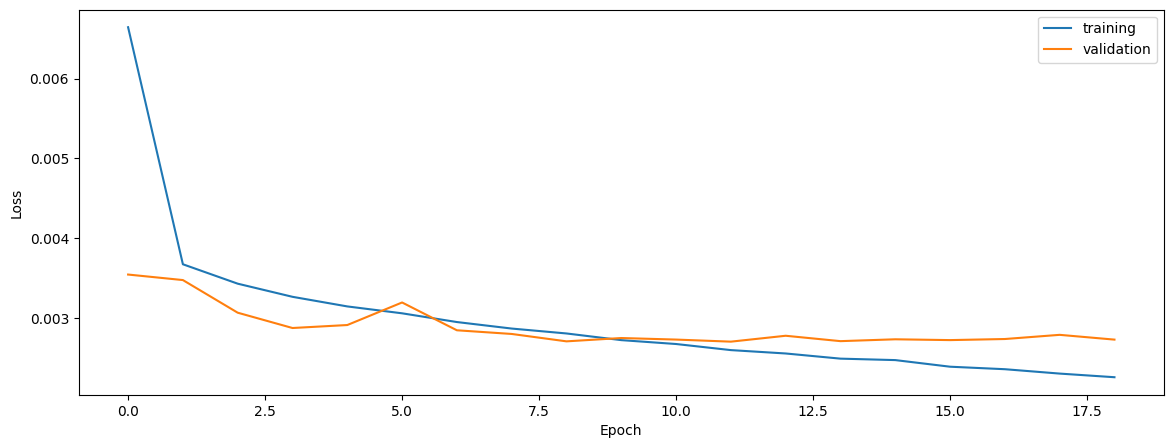

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8556748606225055
0.8310798700360762
0.8253657663119168


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.8556748606225055
0.8310798700360762
0.8253657663119168


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.852389262567102
0.8359520426251035
0.8223509410321934


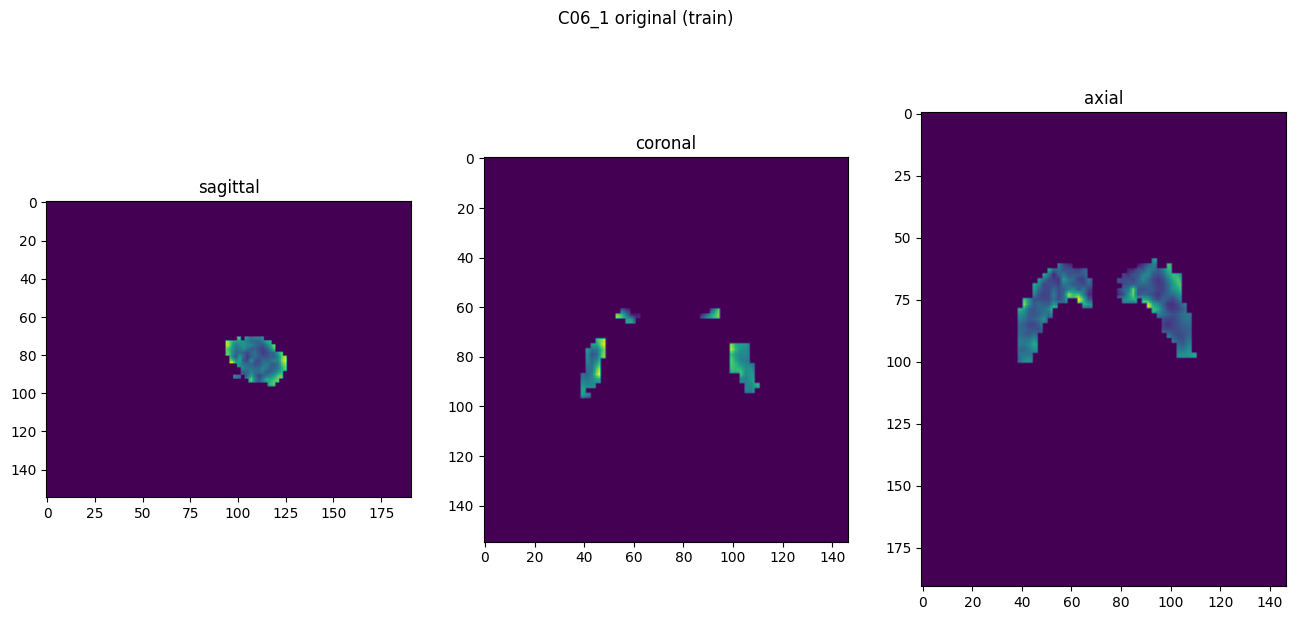

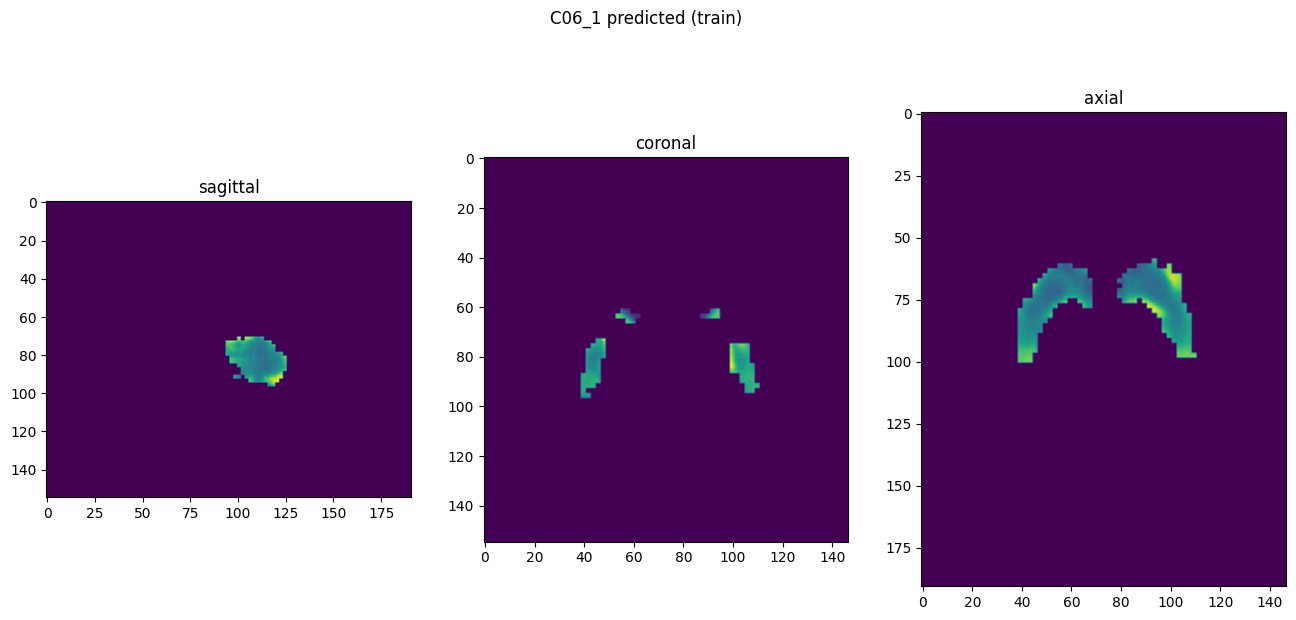

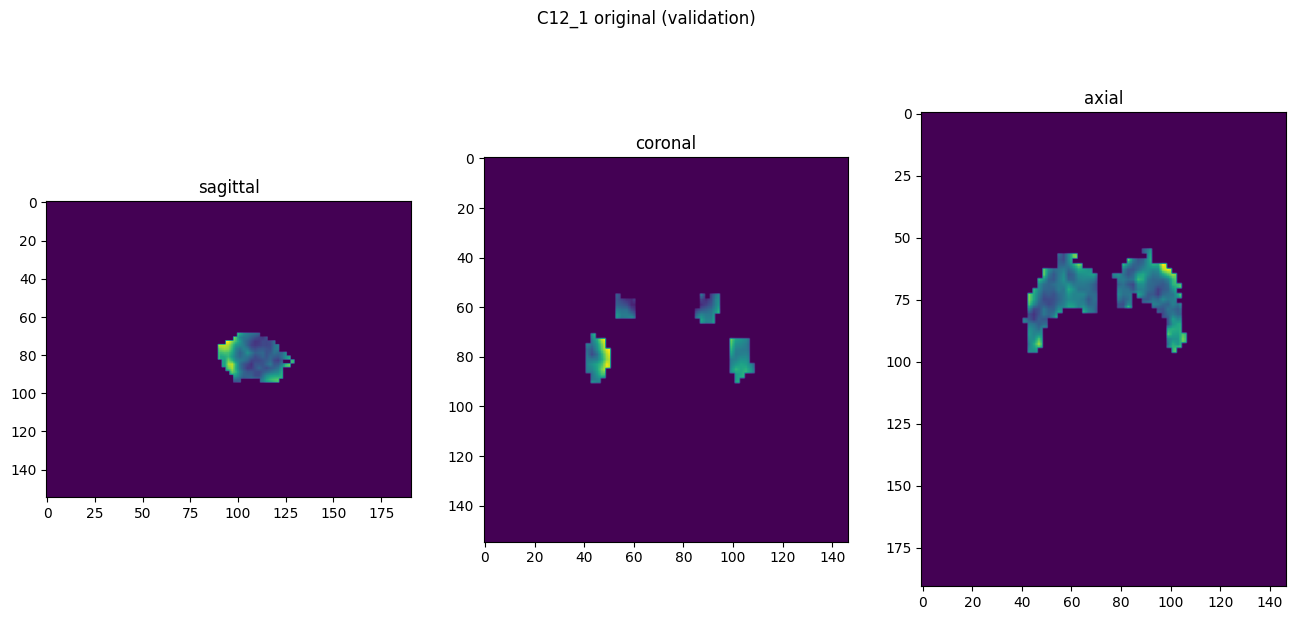

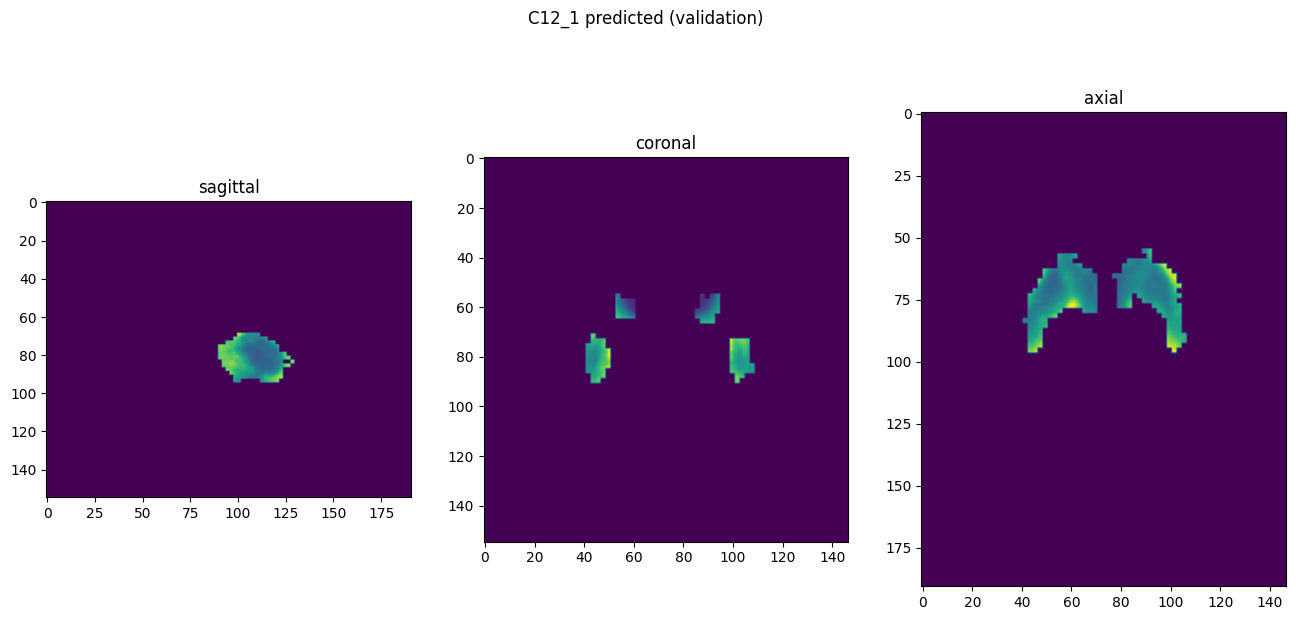

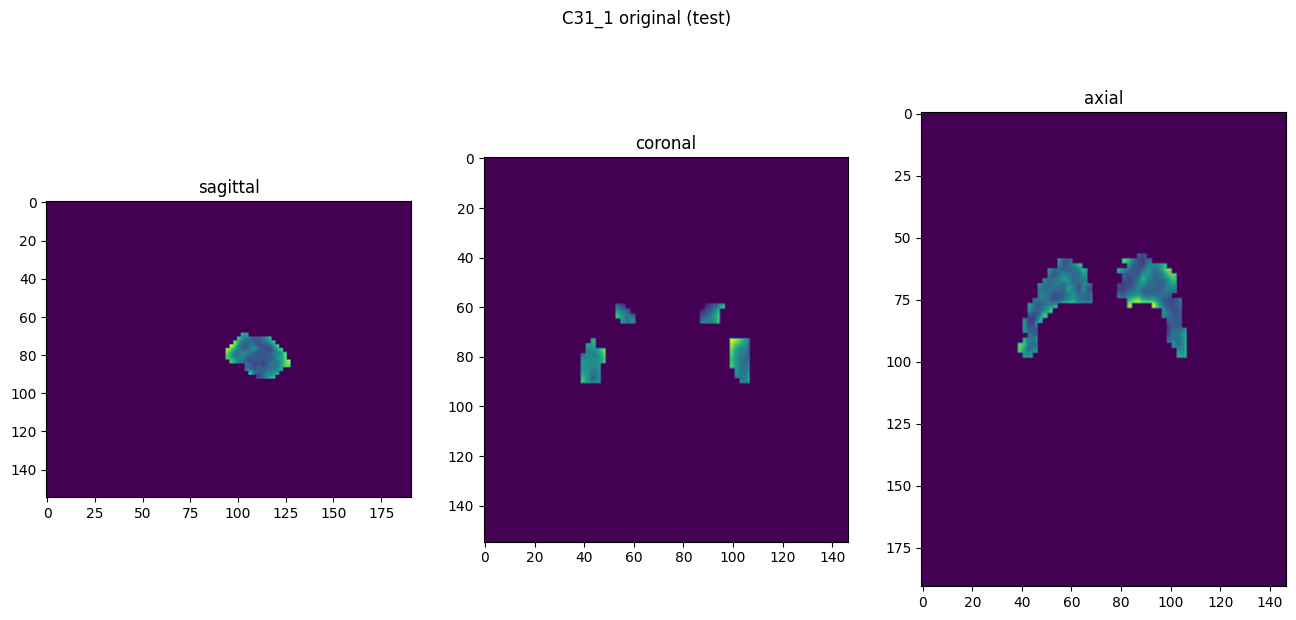

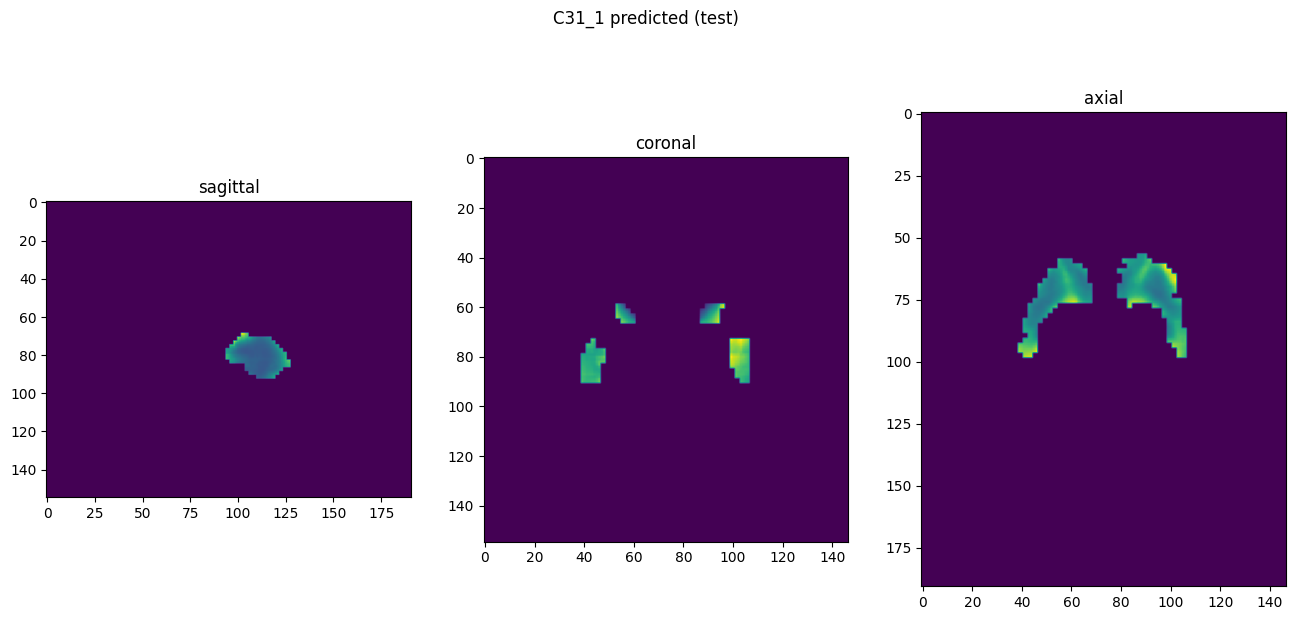

In [10]:
showResults(model, gen, threshold=None, background=False)